In [1]:
!conda activate nlp

#!python -m spacy download en_core_web_lg --user #large spacy language model

In [2]:
import pandas as pd
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import spacy
from spacy.tokens import Doc, Span, Token
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
from datetime import date, timedelta
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import shutil
import glob
import webbrowser
from textblob import TextBlob
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aqqes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Use to download additional Spacy models
#spacy.cli.download("en")

In [4]:
username = os.getlogin()
os.getcwd()

'C:\\Users\\aqqes\\Documents\\GitHub\\bing_news_web_scrapping'

In [5]:
# Use if on Home Desktop
#os.chdir("\\Users\\%s\\Documents\\GitHub\\bing_news_sentiment_analysis" %(username))
#os.chdir("/Users/%s/Documents/GitHub/bing_news_sentiment_analysis" %(username))

In [6]:
# Defining what to search for and what website to search for it on
search_query = '$TSLA'
html_files_folder = "bing_news_html_files"

In [7]:
# Creating empty dataframe and lists to store data
article_df = pd.DataFrame()
article_df['article_id'] = ""
article_df['headline'] = ""
article_df['time'] = ""
article_df['retrieval_date'] = ""
article_df['description'] = ""
article_df['link'] = ""
title_list = []
description_list = []
time_list = []
link_list = []
article_id_list = []

In [8]:
#Navigating through the pages by selecting the next button
import time
driver = webdriver.Chrome(executable_path='Chrome_Driver/chromedriver')
driver.get("https://www.bing.com/news/search?q=%s"\
%(search_query))

SCROLL_PAUSE_TIME = 1

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height


file = open("%s_bing_query.html"%(search_query), 'w')
file.write(driver.page_source)
file.close()
shutil.move("%s_bing_query.html"%(search_query),\
               "%s/%s_bing_query.html"%(html_files_folder,search_query))


driver.close()

In [9]:
html_file_list = glob.glob("bing_news_html_files/*%s*.html"%(search_query))
html_file_list

['bing_news_html_files\\$TSLA_bing_query.html']

In [10]:
# Note that google news HTML references may change at any time
# In order for this cell to work you may need to update the item.find lines to find the most recent data
for file in html_file_list:
    soup = BeautifulSoup(open(file))
    for item in soup.find_all('div', attrs={'class':'news-card newsitem cardcommon b_cards2'}):
        raw_link = (item.find('a',href=True)['href'])
        link = raw_link
        title = (item.find('a',attrs={'class':"title"}).get_text())
        article_info = (item.find('div',attrs={'class':"snippet"}).get_text())
        time = (item.find('span',attrs={'tabindex':"0"}).get_text())
        description = article_info
        title_list.append(title)
        description_list.append(description)
        time_list.append(time)
        link_list.append(link)
        article_id_list.append(random.randint(10000,99999))
        print(title)

Why Tesla (NASDAQ:TSLA) is One of the Best Buys in the S&P 500
Tesla Stock Price and Forecast: Why is TSLA up on Wednesday?
TSLA, NVDA, AAPL, NIO: Why Is the Stock Market Down Today?
Tesla (TSLA) Gains As Market Dips: What You Should Know
Tesla Inc. (NASDAQ: TSLA) Shares Might Go Up 65.14% This Year
Analyst Forecasts $1,000 Price Target for Tesla (TSLA)
How To Buy Tesla (TSLA) Stock
Institutions Own Fewer Tesla, Inc. Shares (NASDAQ:TSLA) Than You Might Think
Why TSLA Stock Investors Should Be Worried About The Rivian IPO
EV Roundup: TSLA Under NTSB Scrutiny, WKHS Drops Suit Against USPS & More
Tesla (TSLA) Crash in Florida Triggers 2nd NTSB Scrutiny This Year
TSLA, NVDA, AAPL, NIO: Why Is the Stock Market Down Today? | Fintech Zoom
One Way Or Another, Rivian Could Make History
Elon Musk Teases Plans For Another Tesla Gigafactory But Says EV Maker Hasn't Zeroed In On Russia
Analyzing Tesla, Inc. (TSLA): Future Growth Catalysts, Hedge Fund Sentiment and Analyst Ratings
Tesla Stops Referr

In [11]:
# Adding data to dataframe
article_df['headline'] = title_list
article_df['time'] = time_list
article_df['description'] = description_list
article_df['link'] = link_list
article_df['article_id'] = article_id_list
article_df['retrieval_date'] = (date.today()).strftime("%m/%d/%Y")

In [12]:
print("Total Articles Retrieved:",len(article_df))

Total Articles Retrieved: 182


In [13]:
article_df.head()

,article_id,headline,time,retrieval_date,description,link
0,53101,Why Tesla (NASDAQ:TSLA) is One of the Best Buy...,1h,09/22/2021,With the stock market pulling back sharply ove...,https://www.entrepreneur.com/article/386956
1,80497,Tesla Stock Price and Forecast: Why is TSLA up...,1h,09/22/2021,Tesla stock outperforms on Tuesday as stocks r...,https://www.fxstreet.com/news/tesla-tsla-stock...
2,18578,"TSLA, NVDA, AAPL, NIO: Why Is the Stock Market...",1d,09/22/2021,"InvestorPlace - Stock Market News, Stock Advic...",https://markets.businessinsider.com/news/stock...
3,69830,Tesla (TSLA) Gains As Market Dips: What You Sh...,14h,09/22/2021,"I n the latest trading session, Tesla (TSLA) c...",https://www.nasdaq.com/articles/tesla-tsla-gai...
4,60472,Tesla Inc. (NASDAQ: TSLA) Shares Might Go Up 6...,17h,09/22/2021,"In today’s recent session, 8.25 million shares...",https://marketingsentinel.com/2021/09/21/tesla...


In [14]:
from spacy.language import Language

In [15]:
#Create a function to get the sentiment
sid = SentimentIntensityAnalyzer()
@Language.component("get_sentiment")
def get_sentiment(doc):
    sentiment_dict = sid.polarity_scores(doc.text)
    sentiment_score = sentiment_dict['compound']
    doc._.set("sentiment_score", sentiment_score)
    if sentiment_score == 0:
        doc._.set("sentiment_category", "neutral")
    elif sentiment_score > 0:
        doc._.set("sentiment_category", "positive")
    elif sentiment_score < 0:
        doc._.set("sentiment_category", "negative")
    else:
        pass
    return doc

In [16]:
# Function to get textblob polarity and subjectivity
@Language.component("get_subjectivity")
def get_subjectivity(doc):
    sub_score = TextBlob(doc.text).subjectivity
    doc._.set("subjectivity_score", sub_score)
    return doc

In [17]:
nlp = spacy.load('en_core_web_lg')
Doc.set_extension("sentiment_score", default=None, force=True)
Doc.set_extension("sentiment_category", default=None, force=True)
Doc.set_extension("subjectivity_score", default=None, force=True)

In [18]:
nlp.add_pipe("get_sentiment", last=True)
nlp.add_pipe("get_subjectivity", last=True)
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'get_sentiment', 'get_subjectivity']


In [19]:
def calculate_sentiment_score(text):
    doc = nlp(text)
    return doc._.sentiment_score

In [20]:
def calculate_subjectivity_score(text):
    doc = nlp(text)
    return doc._.subjectivity_score

In [21]:
def calculate_sentiment_category(text):
    doc = nlp(text)
    return doc._.sentiment_category

In [22]:
def get_article_date(time_text):
    if "d" in time_text:
        days_to_subtract = int(time_text[0])
        article_date = (date.today() - timedelta(days=days_to_subtract)).strftime("%Y-%m-%d")
    elif 'h' in time_text:
        hours_to_subtract = int(time_text[0])
        days_to_subtract  = hours_to_subtract/24
        article_date = (date.today() - timedelta(days=days_to_subtract)).strftime("%Y-%m-%d")
    elif 'mon' in time_text:
        months_to_subtract = int(time_text[0])
        days_to_subtract  = months_to_subtract * 30
        article_date = (date.today() - timedelta(days=days_to_subtract)).strftime("%Y-%m-%d")
    else:
        article_date = None
    return article_date


In [23]:
article_df['hl_sent_score'] = article_df['headline'].apply(calculate_sentiment_score)
article_df['hl_sent_cat'] = article_df['headline'].apply(calculate_sentiment_category)
article_df['hl_sub_score'] = article_df['headline'].apply(calculate_subjectivity_score)

In [24]:
article_df['desc_sent_score'] = article_df['description'].apply(calculate_sentiment_score)
article_df['desc_sent_cat'] = article_df['description'].apply(calculate_sentiment_category)
article_df['desc_sub_score'] = article_df['description'].apply(calculate_subjectivity_score)

In [25]:
article_df['article_date'] = article_df['time'].apply(get_article_date)
article_df['article_date'] = article_df['article_date'].astype(str)

In [26]:
article_df.head()

,article_id,headline,time,retrieval_date,description,link,hl_sent_score,hl_sent_cat,hl_sub_score,desc_sent_score,desc_sent_cat,desc_sub_score,article_date
0,53101,Why Tesla (NASDAQ:TSLA) is One of the Best Buy...,1h,09/22/2021,With the stock market pulling back sharply ove...,https://www.entrepreneur.com/article/386956,0.6369,positive,0.300000,0.0000,neutral,0.291333,2021-09-22
1,80497,Tesla Stock Price and Forecast: Why is TSLA up...,1h,09/22/2021,Tesla stock outperforms on Tuesday as stocks r...,https://www.fxstreet.com/news/tesla-tsla-stock...,0.0000,neutral,0.000000,-0.2732,negative,0.400000,2021-09-22
2,18578,"TSLA, NVDA, AAPL, NIO: Why Is the Stock Market...",1d,09/22/2021,"InvestorPlace - Stock Market News, Stock Advic...",https://markets.businessinsider.com/news/stock...,0.0000,neutral,0.288889,0.0000,neutral,0.850000,2021-09-21
3,69830,Tesla (TSLA) Gains As Market Dips: What You Sh...,14h,09/22/2021,"I n the latest trading session, Tesla (TSLA) c...",https://www.nasdaq.com/articles/tesla-tsla-gai...,0.3400,positive,0.000000,-0.0258,negative,0.291667,2021-09-22
4,60472,Tesla Inc. (NASDAQ: TSLA) Shares Might Go Up 6...,17h,09/22/2021,"In today’s recent session, 8.25 million shares...",https://marketingsentinel.com/2021/09/21/tesla...,0.2960,positive,0.000000,0.5267,positive,0.333333,2021-09-22


In [27]:
import yfinance as yf
from datetime import datetime
ticker_to_search = search_query.replace("$","")

stock = yf.Ticker(ticker_to_search)

In [49]:
dates_of_interest = sorted([ x for x in article_df['article_date'].unique().tolist() if x != "None"])
min_date = datetime.strptime(min(dates_of_interest),"%Y-%m-%d")
max_date =datetime.strptime(max(dates_of_interest),"%Y-%m-%d")
print("Date Range:",min_date,"-",max_date)

Date Range: 2021-03-26 00:00:00 - 2021-09-22 00:00:00


In [30]:
hist = stock.history(start=min_date,end=max_date)

In [31]:
hist.reset_index(inplace=True)
hist.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-03-26,641.869995,643.820007,599.890015,618.710022,33852800,0,0
1,2021-03-29,615.640015,616.479980,596.020020,611.289978,28637000,0,0
2,2021-03-30,601.750000,637.659973,591.010010,635.619995,39432400,0,0
3,2021-03-31,646.619995,672.000000,641.109985,667.929993,33337300,0,0
4,2021-04-01,688.369995,692.419983,659.419983,661.750000,35298400,0,0


In [43]:
hist['Date'] = hist['Date'].astype(str)
hist = hist[["Date","Close"]]

In [44]:
sent_by_date_df = article_df.groupby('article_date').agg({'hl_sent_score':'mean','hl_sub_score':'mean',\
                                                 'desc_sent_score':'mean','desc_sub_score':'mean'})
sent_by_date_df.reset_index(inplace=True)
sent_by_date_df.head()

,article_date,hl_sent_score,hl_sub_score,desc_sent_score,desc_sub_score
0,2021-03-26,0.202300,0.268000,0.000000,0.563333
1,2021-08-23,0.045206,0.236826,0.179970,0.417672
2,2021-09-13,-0.273200,0.000000,0.401900,0.000000
3,2021-09-14,0.002100,0.083333,0.211383,0.272917
4,2021-09-15,0.233333,0.373377,0.292633,0.536616


In [45]:
stock_sent_df = sent_by_date_df.merge(hist, left_on='article_date',right_on='Date',how='left')
#stock_sent_df['article_date'] = pd.to_datetime(pd.Series(stock_sent_df['article_date']), format ="%Y-%m-%d")
stock_sent_df['company'] = search_query
stock_sent_df.head()

,article_date,hl_sent_score,hl_sub_score,desc_sent_score,desc_sub_score,Date,Close,company
0,2021-03-26,0.202300,0.268000,0.000000,0.563333,2021-03-26,618.710022,$TSLA
1,2021-08-23,0.045206,0.236826,0.179970,0.417672,2021-08-23,706.299988,$TSLA
2,2021-09-13,-0.273200,0.000000,0.401900,0.000000,2021-09-13,743.000000,$TSLA
3,2021-09-14,0.002100,0.083333,0.211383,0.272917,2021-09-14,744.489990,$TSLA
4,2021-09-15,0.233333,0.373377,0.292633,0.536616,2021-09-15,755.830017,$TSLA


In [46]:
numerical_features = [x for x in stock_sent_df.columns.tolist() if x not in ["Date","company","article_date","Dividends","Stock Splits"]]

In [47]:
# Which features are highly correlated?
corr = stock_sent_df[numerical_features].corr()
corr.style.background_gradient(cmap='coolwarm')

,hl_sent_score,hl_sub_score,desc_sent_score,desc_sub_score,Close
hl_sent_score,1.000000,0.455669,-0.326409,0.706584,-0.215373
hl_sub_score,0.455669,1.000000,-0.135819,0.392652,-0.106103
desc_sent_score,-0.326409,-0.135819,1.000000,-0.449933,0.546431
desc_sub_score,0.706584,0.392652,-0.449933,1.000000,-0.416638
Close,-0.215373,-0.106103,0.546431,-0.416638,1.000000


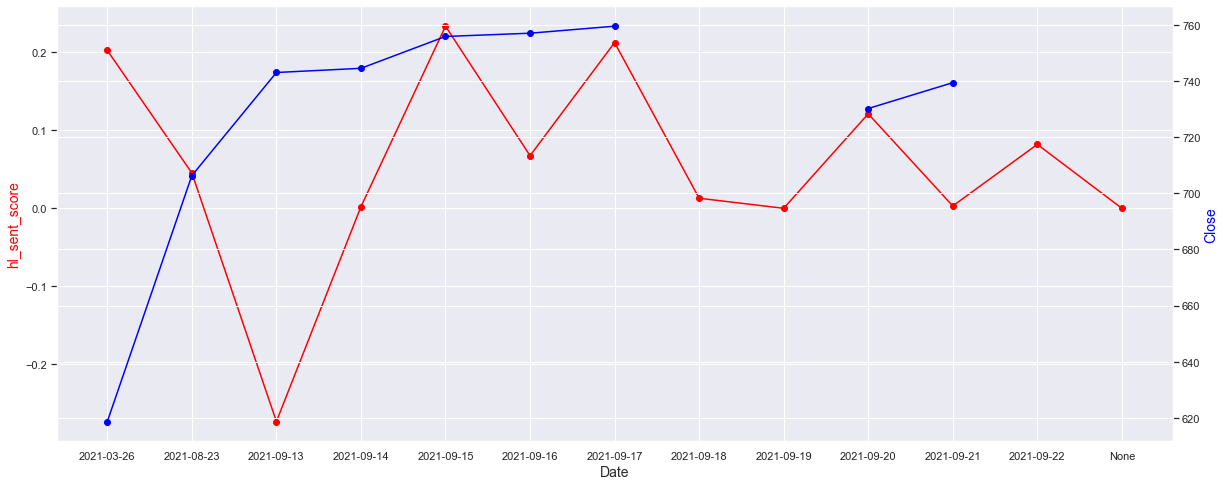

In [62]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(stock_sent_df.article_date, stock_sent_df.hl_sent_score, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("hl_sent_score",color="red",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stock_sent_df.article_date, stock_sent_df["Close"],color="blue",marker="o")
ax2.set_ylabel("Close",color="blue",fontsize=14)
plt.show()


In [ ]:
## What specific entities were mentioned in the article descriptions?
# for i in article_df['description'].tolist():
#     doc = nlp(i)
#     for entity in doc.ents:
#          print(entity.text,":",entity.label_)

In [ ]:
# What do each of the entity tags in these articles represent?
# entity_tags =[]
# for i in article_df['description'].tolist():
#     doc = nlp(i)
#     for entity in doc.ents:
#         entity_tags.append(entity.label_)

# entity_tags = set(entity_tags)
# for tag in entity_tags:
#     print(tag,":",spacy.explain(tag))
      

In [ ]:
# What is the sentiment socre associated with each articles description?
# x = 0
# for description in article_df['description'].tolist():
#     doc = nlp(description)
#     print(article_df['title'][x],':', doc._.sentiment_score)
#     x+=1